In [15]:
# Problem 1 (a)
import pandas as pd
Auto = pd.read_csv("Auto.csv", na_values=["?"])

# check the data cleanliness
#print(Auto.info())
#print(Auto.isna().sum())
#print(Auto.head())

mpg_median = Auto["mpg"].median()
print(mpg_median) 

Auto["mpg01"] = (Auto["mpg"] > mpg_median).astype(int)
print(Auto["mpg01"].value_counts())
print(Auto[["mpg", "mpg01"]].head(10))

22.75
mpg01
0    196
1    196
Name: count, dtype: int64
    mpg  mpg01
0  18.0      0
1  15.0      0
2  18.0      0
3  16.0      0
4  17.0      0
5  15.0      0
6  14.0      0
7  14.0      0
8  14.0      0
9  15.0      0


Note: you may need to restart the kernel to use updated packages.


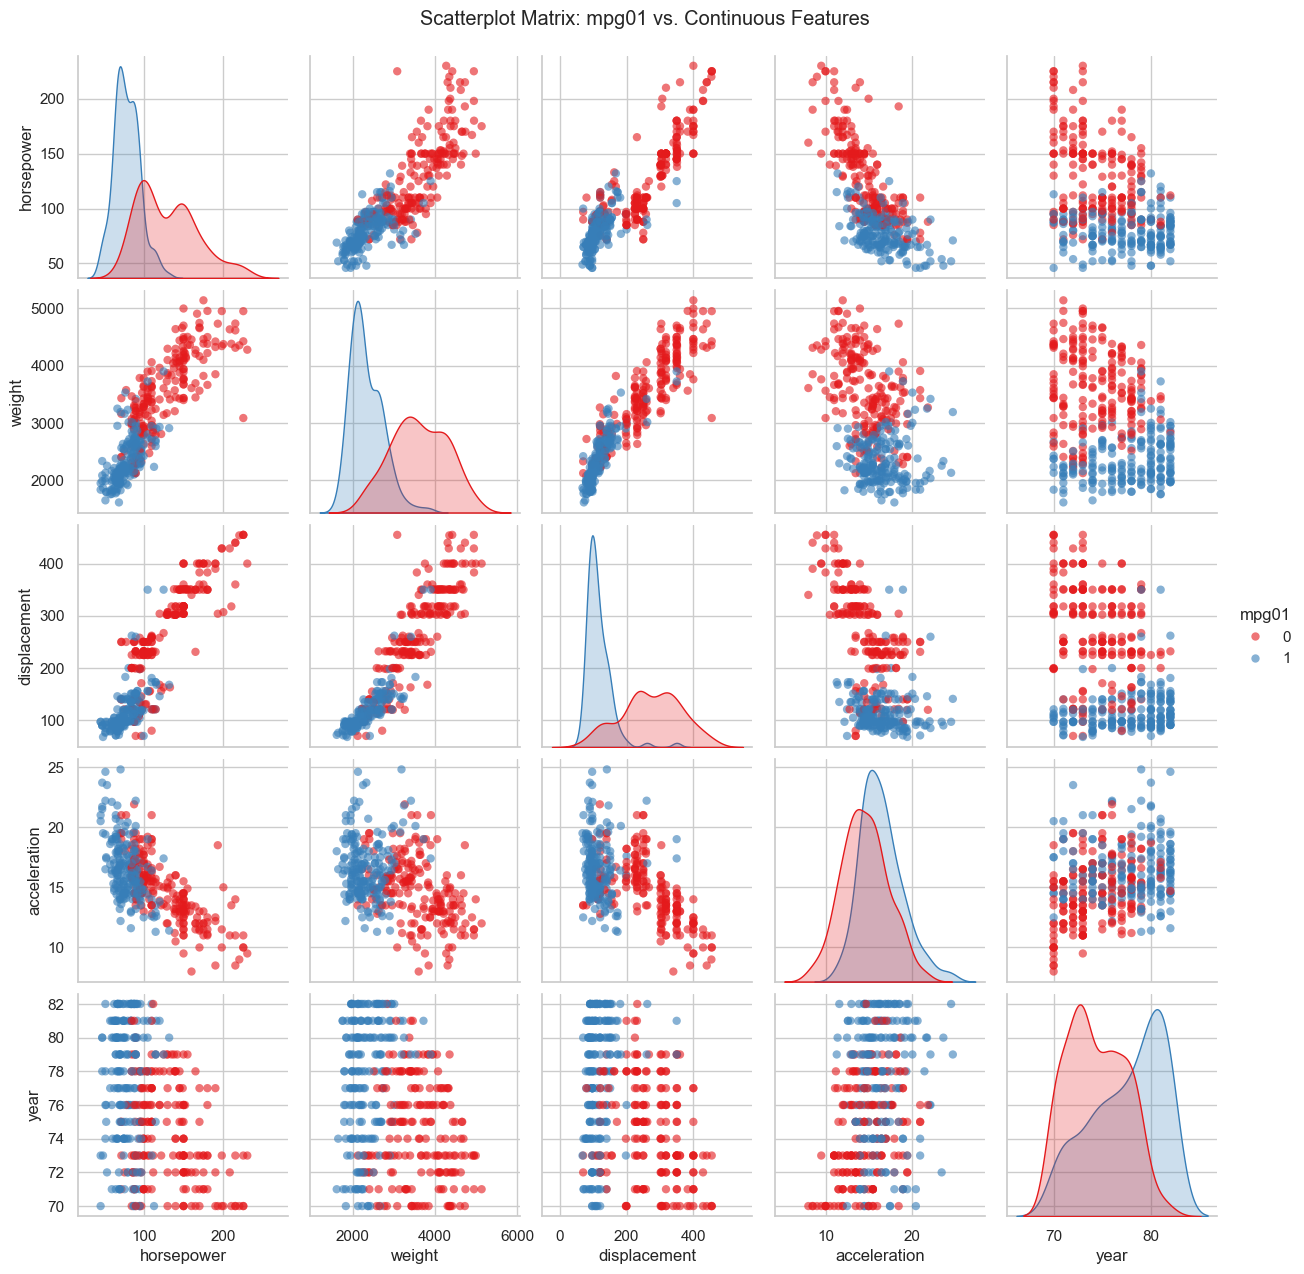

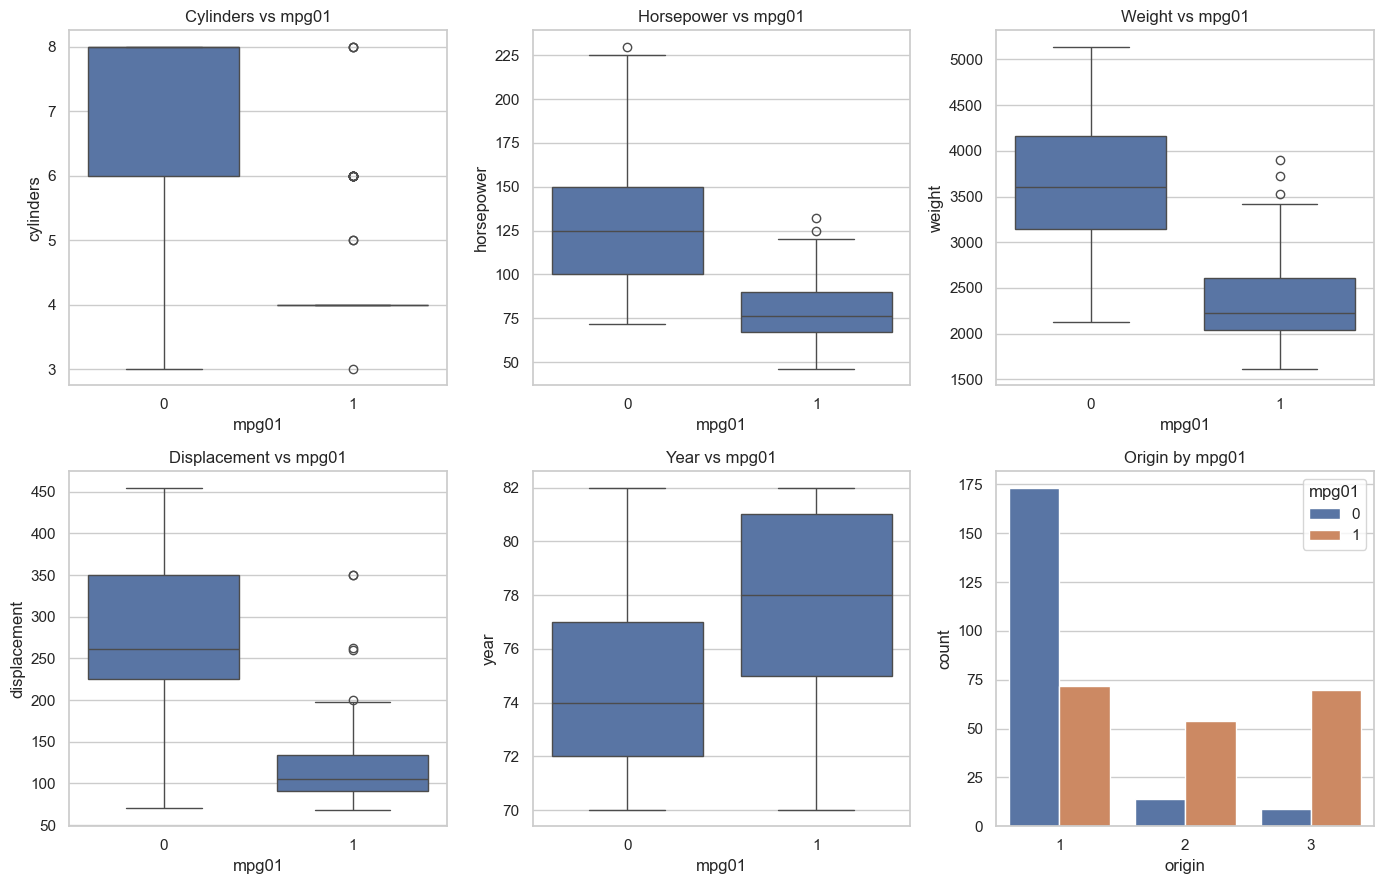

Findings:
- mpg01=1 (high mpg) cars concentrate at LOWER horsepower, weight, and displacement; mpg01=0 at HIGHER values.
- Cylinders: strong separation—high mpg mostly 4 cylinders; low mpg often 6–8 cylinders.
- Acceleration: weak discriminator—distributions overlap substantially across mpg01 groups.
- Year: clear temporal trend—newer model years (late '70s–early '80s) correspond to higher mpg.
- Origin: composition differs by region—Origin 1 skews toward low mpg, while Origins 2–3 have a higher share of high-mpg cars.



In [16]:
# Problem 1 (b) — exploratory plots

%pip install seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure numeric types and drop NA to avoid plotting issues
Auto["horsepower"] = pd.to_numeric(Auto["horsepower"], errors="coerce")
Auto["weight"] = pd.to_numeric(Auto["weight"], errors="coerce")
Auto["displacement"] = pd.to_numeric(Auto["displacement"], errors="coerce")
Auto["acceleration"] = pd.to_numeric(Auto["acceleration"], errors="coerce")
Auto["year"] = pd.to_numeric(Auto["year"], errors="coerce")
Auto["cylinders"] = pd.to_numeric(Auto["cylinders"], errors="coerce")
Auto["origin"] = pd.to_numeric(Auto["origin"], errors="coerce")
Auto = Auto.dropna(subset=["mpg01","horsepower","weight","displacement","acceleration","year","cylinders","origin"])

sns.set_theme(style="whitegrid")

# Scatterplot matrix for continuous features
g = sns.pairplot(
    Auto,
    vars=["horsepower", "weight", "displacement", "acceleration", "year"],
    hue="mpg01",
    palette="Set1",
    diag_kind="kde",
    plot_kws=dict(alpha=0.6, edgecolor="none")
)
g.fig.suptitle("Scatterplot Matrix: mpg01 vs. Continuous Features", y=1.02)
plt.show()

# Boxplots for variables strongly associated with mpg01
fig, axes = plt.subplots(2, 3, figsize=(14, 9))

sns.boxplot(x="mpg01", y="cylinders", data=Auto, ax=axes[0,0])
axes[0,0].set_title("Cylinders vs mpg01")

sns.boxplot(x="mpg01", y="horsepower", data=Auto, ax=axes[0,1])
axes[0,1].set_title("Horsepower vs mpg01")

sns.boxplot(x="mpg01", y="weight", data=Auto, ax=axes[0,2])
axes[0,2].set_title("Weight vs mpg01")

sns.boxplot(x="mpg01", y="displacement", data=Auto, ax=axes[1,0])
axes[1,0].set_title("Displacement vs mpg01")

sns.boxplot(x="mpg01", y="year", data=Auto, ax=axes[1,1])
axes[1,1].set_title("Year vs mpg01")

# origin is categorical (1,2,3) -> use countplot with hue by mpg01
sns.countplot(x="origin", hue="mpg01", data=Auto, ax=axes[1,2])
axes[1,2].set_title("Origin by mpg01")

fig.tight_layout()
plt.show()

# brief summary of findings
print(
    "Findings:\n"
    "- mpg01=1 (high mpg) cars concentrate at LOWER horsepower, weight, and displacement; mpg01=0 at HIGHER values.\n"
    "- Cylinders: strong separation—high mpg mostly 4 cylinders; low mpg often 6–8 cylinders.\n"
    "- Acceleration: weak discriminator—distributions overlap substantially across mpg01 groups.\n"
    "- Year: clear temporal trend—newer model years (late '70s–early '80s) correspond to higher mpg.\n"
    "- Origin: composition differs by region—Origin 1 skews toward low mpg, while Origins 2–3 have a higher share of high-mpg cars.\n"
)



## Problem 1 (b)

### Scatterplots
Scatterplots are best for continuous variables. From the matrix we see **clear separation** by `mpg01` for **horsepower**, **weight**, and **displacement**—high-mpg cars cluster at lower values, while low-mpg cars are heavier, more powerful, and larger-displacement.  
**Acceleration** shows **weak separation** (substantial overlap).  
**Year** exhibits a **positive trend** with mpg: newer model years are more often high-mpg.

**Conclusion from scatterplots:** The strongest continuous predictors are **horsepower**, **weight**, and **displacement**; **acceleration** contributes little; **year** captures a temporal trend.

### Boxplots
Boxplots compare distributions across the binary `mpg01` groups. We observe strong separation for **cylinders** (high mpg ≈ **4-cyl**; low mpg ≈ **6–8 cyl**), and again for **horsepower**, **weight**, and **displacement**.  
For **origin**, the composition differs by region (Origin 1 skews low-mpg, while Origins 2–3 include more high-mpg cars).

### Overall findings
The features most useful for predicting `mpg01` are **cylinders**, **horsepower**, **weight**, and **displacement**.  
`Year` is positively associated with mpg (technology/efficiency gains) but is not essential for our main model; **acceleration** provides limited additional separation.  


In [ ]:
# Problem 1 (c)

from sklearn.model_selection import train_test_split
import pandas as pd

# target only
y = Auto["mpg01"]

# one-and-only split (stratify keeps 0/1 proportion)
idx_train, idx_test = train_test_split(
    Auto.index, test_size=0.30, random_state=1, stratify=y
)

features_main = ["cylinders", "horsepower", "weight", "displacement"]

# convenience slices for later
X_train_main = Auto.loc[idx_train, features_main]
X_test_main  = Auto.loc[idx_test,  features_main]
y_train = y.loc[idx_train]
y_test  = y.loc[idx_test]

print("Training size:", len(idx_train))
print("Test size:", len(idx_test))


Training size: 274
Test size: 118


In [29]:
# Problem 1 (d): LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_main, y_train)
y_pred = lda.predict(X_test_main)
acc_lda = accuracy_score(y_test, y_pred)
print(f"LDA Test Accuracy: {acc_lda:.3f}")
print(f"LDA Test Error: {1-acc_lda:.3f}")


LDA Test Accuracy: 0.898
LDA Test Error: 0.102


## Problem 1 (d)

Based on the exploratory analysis in part (b), we selected **cylinders, horsepower, weight, and displacement** as the predictors for the LDA model.

Using the same train–test split from part (c), the LDA model achieved a **test accuracy of 89.8%** (test error **10.2%**).

This performance indicates that most predictive power is captured by these four engine/weight–related features, consistent with the patterns observed in (b).


In [30]:
# Problem 1 (e): QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_main, y_train)
y_pred = qda.predict(X_test_main)
acc_qda = accuracy_score(y_test, y_pred)
print(f"QDA Test Accuracy: {acc_qda:.3f}")
print(f"QDA Test Error: {1-acc_qda:.3f}")


QDA Test Accuracy: 0.890
QDA Test Error: 0.110


## Problem 1 (e)

Using the same four predictors (**cylinders, horsepower, weight, displacement**) identified in part (b), we fit a Quadratic Discriminant Analysis (QDA) model on the training data.

The QDA model achieved a **test accuracy of 89.0%** (test error **11.0%**), which is **slightly worse** than the LDA model (89.8% accuracy).

This suggests that a **linear decision boundary is sufficient** for this problem; the added flexibility of QDA does not improve—and here slightly harms—generalization performance.


In [34]:
# Problem 1 (f): Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_main, y_train)
y_pred = log_reg.predict(X_test_main)
acc_log = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Test Accuracy: {acc_log:.3f}")
print(f"Logistic Regression Test Error: {1-acc_log:.3f}")


Logistic Regression Test Accuracy: 0.890
Logistic Regression Test Error: 0.110


## Problem 1 (f)

Using the same four predictors — **cylinders, horsepower, weight, and displacement** — we fitted a logistic regression model to predict `mpg01`.

The model achieved a **test accuracy of 89.0%** (test error **11.0%**), which is **slightly below** the LDA model (89.8% accuracy).

This is still consistent with expectations because both logistic regression and LDA impose a **linear decision boundary**; hence their performances are typically close. Logistic regression attains comparable accuracy while relaxing LDA’s Gaussian-equal-covariance assumption.

In [35]:
# Problem 1 (g): Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_main, y_train)
y_pred = nb.predict(X_test_main)
acc_nb = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Test Accuracy: {acc_nb:.3f}")
print(f"Naive Bayes Test Error: {1-acc_nb:.3f}")


Naive Bayes Test Accuracy: 0.890
Naive Bayes Test Error: 0.110


## Problem 1 (g)

Using the same four predictors (**cylinders, horsepower, weight, displacement**), the Naive Bayes classifier achieved a **test accuracy of 89.0%** (test error **11.0%**), which is **slightly below** LDA (89.8%) and similar to logistic regression (89.0%).

This result is reasonable: although the predictors are largely monotonic with respect to mpg (yielding near-linear separation), Naive Bayes assumes **conditional independence** among features—a condition that is violated here because cylinders, displacement, and weight are highly correlated. That violation can increase variance or bias in the class-conditional likelihoods, resulting in performance that is close to—but not better than—the linear methods.

In [37]:
# Problem 1 (h): KNN (with scaling)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(X_train_main)
Xte_scaled = scaler.transform(X_test_main)

k_values = [1, 3, 5, 7, 9, 15, 25]
knn_results = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtr_scaled, y_train)
    y_pred = knn.predict(Xte_scaled)
    acc = accuracy_score(y_test, y_pred)
    knn_results.append((k, acc, 1-acc))
    print(f"K = {k:2d} | Test Accuracy = {acc:.3f} | Test Error = {1-acc:.3f}")


K =  1 | Test Accuracy = 0.907 | Test Error = 0.093
K =  3 | Test Accuracy = 0.890 | Test Error = 0.110
K =  5 | Test Accuracy = 0.907 | Test Error = 0.093
K =  7 | Test Accuracy = 0.907 | Test Error = 0.093
K =  9 | Test Accuracy = 0.898 | Test Error = 0.102
K = 15 | Test Accuracy = 0.890 | Test Error = 0.110
K = 25 | Test Accuracy = 0.890 | Test Error = 0.110


## Problem 1 (h) — KNN

Using the same four predictors (**cylinders, horsepower, weight, displacement**), we applied KNN with several values of \(K\).  
All predictors were standardized since KNN is sensitive to feature scale.

| K | Test Accuracy | Test Error |
|---|---------------|------------|
| 1 | 0.907 | 0.093 |
| 3 | 0.890 | 0.110 |
| 5 | 0.907 | 0.093 |
| 7 | 0.907 | 0.093 |
| 9 | 0.898 | 0.102 |
| 15 | 0.890 | 0.110 |
| 25 | 0.890 | 0.110 |

**Findings.** The lowest test error (**9.3%**) occurs at **K = 1, 5, 7** (tie).  
In case of ties, we prefer a **moderate K (e.g., K = 7)** for lower variance and better robustness.  
Performance plateaus or degrades slightly for larger \(K\), indicating mild underfitting.


### Variable Choice Summary

**Observation.** In additional trials, replacing **cylinders** with **year** (i.e., using {year, horsepower, weight, displacement}) yielded **slightly higher test accuracy**. This is plausible because **year** captures technological/efficiency improvements over time and is less collinear with engine/weight variables.

**Why I still use `cylinders` in the main analysis:**
- **Consistency with (b):** The EDA in part (b) showed the **clearest separation** for `cylinders` (along with horsepower, weight, displacement). To avoid data snooping, I pre-specified the predictors from (b) and used them in (d)–(h).
- **Interpretability:** `cylinders` directly reflects engine architecture; the direction of effect (fewer cylinders → higher mpg) is transparent.
- **Comparable performance:** While `year` can be marginally better on this split, overall conclusions **do not change**. Results with `year` serve as a **robustness check** confirming the main findings.

*Takeaway:* I report models with **{cylinders, horsepower, weight, displacement}** as the primary specification, and note that substituting **year** for **cylinders** produces similar (sometimes slightly better) accuracy, reinforcing the robustness of the results.


In [23]:
# Problem 2 (a)
import numpy as np
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

## Problem 2 (a) Simulated Data

- **n = 100** (100 observations generated using `size=100`)  
- **p = 1** (one predictor, \(x\); note : (x^2) is a transformation of (x), not a separate variable)

### Data-generating model:

$$
x_i \sim \mathcal{N}(0,1), \quad
y_i = x_i - 2x_i^{2} + \varepsilon_i, \quad
\varepsilon_i \sim \mathcal{N}(0,1), \quad i = 1, \dots, 100
$$


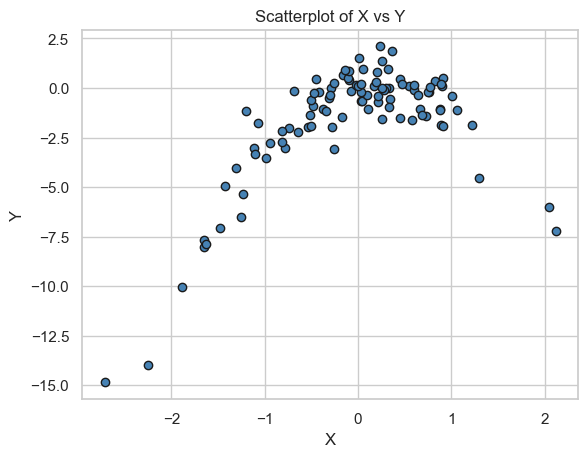

In [24]:
# Problem 2 (b)
import matplotlib.pyplot as plt
import numpy as np

# Simulated data
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

# Scatterplot
plt.scatter(x, y, color="steelblue", edgecolor="k")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatterplot of X vs Y")
plt.show()

## (b) Scatterplot of X vs Y

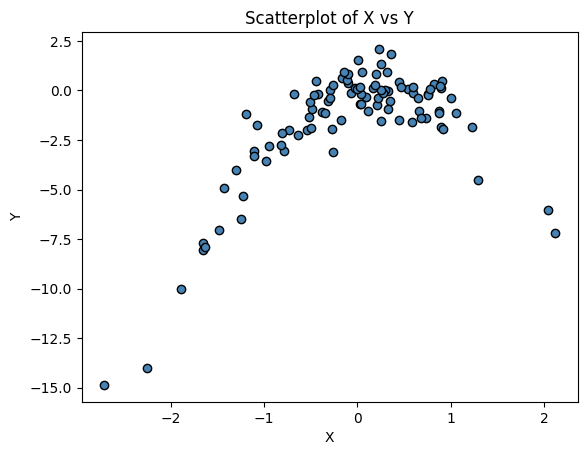

### Comment:

The scatterplot shows a **clear nonlinear relationship** between X and Y  

As X increases,Y first rises and then falls, forming an **inverted U-shaped pattern**.  

This curvature reflects the underlying quadratic term in the data-generating process:

$$
y = x - 2x^2 + \varepsilon
$$

The negative coefficient on x^2 causes Y to decrease when |X| becomes large.


In [25]:
# Problem 2 (c)
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score

rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

data = pd.DataFrame({"x": x, "y": y})

loo = LeaveOneOut()

def loocv_mse(degree):
    # create polynomial features up to 'degree'
    X_poly = np.vander(x, N=degree+1, increasing=True)[:, 1:]  # exclude intercept column
    model = LinearRegression()
    # negative MSE (so take negative after mean)
    scores = cross_val_score(model, X_poly, y, cv=loo, scoring="neg_mean_squared_error")
    return -scores.mean()

degrees = [1, 2, 3, 4]
errors = [loocv_mse(d) for d in degrees]

results = pd.DataFrame({"Degree": degrees, "LOOCV MSE": errors})
print(results)

   Degree  LOOCV MSE
0       1   6.633030
1       2   1.122937
2       3   1.301797
3       4   1.332394


## Problem 2 (c)

We fit polynomial regression models of degree 1 to 4 using least squares and computed the Leave-One-Out Cross-Validation (LOOCV) mean squared error (MSE).

| Degree | LOOCV MSE |
|:-------:|:---------:|
| 1 | 6.633 |
| 2 | **1.123** |
| 3 | 1.302 |
| 4 | 1.332 |

### Comment:
The LOOCV error is smallest for the **quadratic model (degree = 2)**, indicating that a second-degree polynomial provides the best fit.

This is consistent with the true data-generating process  

$$
y = x - 2x^2 + \varepsilon,
$$

which is quadratic in x. Higher-degree models add unnecessary complexity and slightly increase the validation error.

### Why use LOOCV here

Although the true data-generating process is quadratic $$y = x - 2x^2 + \varepsilon$$
in practice we would not know this functional form.  

The purpose of LOOCV is to **mimic real-world model selection**,  
allowing us to compare models of different polynomial degrees and estimate their prediction errors.  

LOOCV correctly identifies the quadratic model (degree = 2) as the one with the lowest test error,  
showing that it best captures the underlying relationship without overfitting.


In [26]:
# Problem (d) - Repeat LOOCV with a different random seed
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score

# new random seed
rng = np.random.default_rng(2)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

loo = LeaveOneOut()

def loocv_mse(degree):
    X_poly = np.vander(x, N=degree+1, increasing=True)[:, 1:]
    model = LinearRegression()
    scores = cross_val_score(model, X_poly, y, cv=loo, scoring="neg_mean_squared_error")
    return -scores.mean()

degrees = [1, 2, 3, 4]
errors_new = [loocv_mse(d) for d in degrees]

results_new = pd.DataFrame({"Degree": degrees, "LOOCV MSE": errors_new})
print(results_new)


   Degree  LOOCV MSE
0       1   7.560604
1       2   0.984037
2       3   0.968236
3       4   0.965959


## Problem 2 (d) LOOCV with a Different Random Seed

| Degree | LOOCV MSE |
|:-------:|:---------:|
| 1 | 7.561 |
| 2 | 0.984 |
| 3 | 0.968 |
| 4 | 0.966 |

### Comment:

The LOOCV errors differ slightly from part (c) because a different random seed  
generates new random noise in the simulated data.  

However, the overall pattern remains consistent — models of degree 2 to 4  
perform much better than the linear model (degree 1),  
and the **quadratic and cubic models** achieve the lowest errors.  

This shows that while random variation affects the exact MSE values,  
the cross-validation results are stable in identifying the correct (approximately quadratic) relationship.


## Problem 2 (e)

From part (c), the **quadratic model (degree = 2)** had the smallest LOOCV error (1.123).  
This result is exactly what we would expect, because the simulated data were generated from the model

$$
y = x - 2x^2 + \varepsilon,
$$

which is quadratic in \(x\).  

Therefore, the second-degree polynomial captures the true relationship most accurately,  
while higher-degree models introduce unnecessary complexity and slightly overfit the data.


In [27]:
# Problem2 (f)
import statsmodels.api as sm
import numpy as np

rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)

def fit_poly(degree):
    X_poly = np.vander(x, N=degree+1, increasing=True)
    model = sm.OLS(y, X_poly).fit()
    return model.summary()

for d in range(1, 5):
    print(f"\n=== Degree {d} Model ===")
    print(fit_poly(d))



=== Degree 1 Model ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     45.60
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           1.04e-09
Time:                        16:00:07   Log-Likelihood:                -230.83
No. Observations:                 100   AIC:                             465.7
Df Residuals:                      98   BIC:                             470.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4650      0

## Problem 2 (f) Significance of Coefficient Estimates

| Model | Significant Terms (p < 0.05) | R² | Comment |
|:------|:-----------------------------|:----:|:---------|
| **Degree 1** | Intercept, X | 0.318 | Linear model underfits; fails to capture curvature. |
| **Degree 2** | X, X² | 0.887 | Both terms highly significant; best fit to true quadratic pattern. |
| **Degree 3** | X, X² | 0.888 | X³ not significant (p = 0.287); unnecessary term. |
| **Degree 4** | X, X², X⁴ | 0.894 | Slightly higher R², but X³ not significant and LOOCV error increases → overfitting. |

### Comment:

Only the **quadratic model (degree = 2)** includes statistically significant predictors that correspond to the true data-generating process  

$$
y = x - 2x^2 + \varepsilon.
$$

Although the quartic model shows a marginally higher R^2, this improvement is due to overfitting noise rather than capturing genuine structure.

These findings are consistent with the LOOCV results, confirming that the quadratic model provides the best balance between fit and simplicity.



## Problem 3 (a) Smallest Training RSS

For a given number of predictors k:

- Best subset selection examines all possible combinations of k predictors and chooses the model with the lowest training RSS.
- Forward and backward stepwise selection are greedy methods that consider only a limited subset of possible models.

Therefore, the best subset model will always have the smallest (or equal-smallest) training RSS among the three approaches for the same k.


## Problem 3 (b) Smallest test RSS for a given k

There is no guarantee that any one approach (best subset, forward stepwise, backward stepwise) will always have the smallest test RSS for the same k.

- All three produce k-predictor models (same nominal complexity), but:
  - **Best subset** searches more models → **lower training RSS** but **higher selection variance**, so it can overfit the training noise and yield **higher test RSS**.
  - **Forward/backward stepwise** search fewer models → slightly more bias but **lower variance**, which can sometimes give **lower test RSS**.

**Conclusion:** The method with the smallest **test** RSS depends on the data (bias–variance trade-off). must compare them via a validation set or cross-validation; no approach is guaranteed to win for test error at a fixed k.


## Problem 3 (c)(i) 

**True.**  

In forward stepwise selection start with no predictors and add exactly one new predictor at each step without removing previously chosen ones.  

Therefore, the predictors in the k-variable model are a subset of those in the k+1-variable model selected by the same forward stepwise procedure.


## Problem 3 (c)(ii) 

**True.**  

In backward stepwise selection, start with all predictors and, at each step, remove exactly one predictor (and never add any back).  

Therefore, the set of predictors in the k-variable model is a subset of the predictors in the k+1 -variable model along the same backward stepwise path.

## Problem 3 (c)(iii) 

**False.**  

The k-variable model from backward stepwise and the k+1 -variable model from forward stepwise are produced by different search paths, so their predictor sets need not be nested.

*Why:* 

Forward adds variables greedily from an empty set; backward removes variables greedily from the full set. With correlated predictors, each procedure can choose different variables.

*Counterexample:*  

With predictors $X_1, X_2, X_3$:
- Forward for k+1=2 might select $X_1, X_2$.
- Backward for k=1 might retain only $X_3$.

Then $X_3$ is **not** a subset of $X_1, X_2$.


## Problem 3 (c)(iv) 

**False.**  

Forward and backward stepwise follow different search paths (add-one vs. drop-one). Their selected models at adjacent sizes are not guaranteed to be nested across procedures.

*Counterexample:*

With predictors $X_1, X_2, X_3$:
- Forward (k = 1) selects: X1  
- Backward (k+1 = 2) retains: {X2, X3}  

Then {X1} is **not** a subset of {X2, X3}.

## Problem 3 (c)(v) 

**False.**  

In best subset selection, the “best” k-variable model and the “best” k+1 -variable model are chosen independently to minimize training RSS at each size.  

Therefore, the predictors in the k-variable best model are not guaranteed to be contained in the k+1 -variable best model.

*Counterexample*  

Predictors: X1, X2, X3  

- Best k=1 model: {X1} (lowest 1-variable RSS)  
- Best k+1=2 model: {X2, X3} (together they beat {X1, X2} and {X1, X3})  

Then {X1} not nested {X2, X3}; models are **not nested** under best subset selection.

## Problem 4 (a)

### Correct choice: (iii)

Less flexible, and thus it will improve prediction accuracy when its increase in bias is less than its decrease in variance.

### Justification:

OLS is more flexible -> low bias, high variance (prone to overfitting).

Lasso adds an L1 penalty -> shrinks/zeros coefficients -> less flexible, raising bias but reducing variance.

If the variance reduction outweighs the bias increase, the test error decreases, yielding better prediction—exactly statement (iii).

## Problem 4 (b)

### Correct choice: (iii)

### Justification:

Ridge regression is less flexible than least squares because the L2 penalty shrinks coefficients toward zero, which increases bias but reduces variance. When the reduction in variance exceeds the increase in bias, the test error decreases and prediction accuracy improves—hence choice (iii). (Unlike lasso, ridge typically does not set coefficients exactly to zero.)

## Problem 4 (c)

### Correct choice: (ii)

### Justification:

Non-linear methods are more flexible than least squares, typically reducing bias but increasing variance. They improve prediction when the increase in variance is smaller than the decrease in bias, so the net test error drops—hence (ii).